In [2]:
from roboflow import Roboflow
import cv2
import numpy as np
from pdf2image import convert_from_path
import PIL
import easyocr
import os
import copy

import matplotlib.pyplot as plt
from PIL import ImageDraw, ImageFont, Image
rf = Roboflow(api_key="AmMUXsxw896FwSFt1GP7")
project = rf.workspace().project("sinotech")
model = project.version(2).model

loading Roboflow workspace...
loading Roboflow project...


# 目標:

### Step1： PDF轉JPG並做預處理

In [107]:
# turn pdf to jpg
path = "../../data/pdf/SheetPile/eval1.pdf"
images = convert_from_path(path, dpi =210)
cv2_img = cv2.cvtColor(np.asarray(images[0]),cv2.COLOR_RGB2BGR)
img_gray = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2GRAY)
img_gray = cv2.rotate(img_gray, cv2.ROTATE_90_COUNTERCLOCKWISE)
_, img_th = cv2.threshold (img_gray, 240, 255, 0)
img_blur = cv2.GaussianBlur(img_th, (5, 5), 0)

cv2.imwrite("input.jpg", img_blur)

True

In [3]:
img_blur = cv2.imread("input.jpg")

### Step2： 用roboflow的模型做section的偵測

In [4]:
# put image to model
result = model.predict(img_blur, confidence=10, overlap=30).json()

#### Visuale the model prediction

In [5]:
model.predict("input.jpg", confidence=10, overlap=30).save("prediction.jpg")

### STEP3：依照模型辨識出的section位置將圖說進行切割

In [6]:
def block_split(result):
    img_left = 80
    img_top = 80
    img_right = 2990
    img_bottom = 2400
    sorted_instance = sorted(result['predictions'], key=lambda k: k['y'])

    section_bbox_list = []
    dummy_y = 0
    temp_section_list = []

    # split the section according to y to represent each row
    for i, instance in enumerate(sorted_instance):
        x, y, w, h= instance['x'], instance['y'], instance['width'], instance['height']
        if y > (dummy_y + 100) and i != 0:
          # sort the temp section list by x and then append temp_section_list to section_bbox_list
          temp_section_list = sorted(temp_section_list, key=lambda k: k[0])
          section_bbox_list.append(copy.deepcopy(temp_section_list))
          # clear temp_section_list
          temp_section_list.clear()
          temp_section_list.append([x, y, w, h])
          dummy_y = y
        else:
          temp_section_list.append([x, y, w, h])
          dummy_y = y

    temp_section_list = sorted(temp_section_list, key=lambda k: k[0])
    section_bbox_list.append(copy.deepcopy(temp_section_list))
          
    # delete temp_section_list and dummy_y
    del temp_section_list
    del dummy_y
    
    # split each section into blocks
    block = []
    for i in range(len(section_bbox_list)):
        for j in range(len(section_bbox_list[i])):
            temp_block = [0,0,0,0]
            # if it is the first block
            if i == 0:
                temp_block[1] = img_top
            else:
                temp_block[1] = section_bbox_list[i-1][j][1] + section_bbox_list[i-1][j][3]/2

            # if it is the last block
            if i == len(section_bbox_list)-1:
                temp_block[3] = img_bottom
            else:
                temp_block[3] = section_bbox_list[i][j][1] + section_bbox_list[i][j][3]/2

            # if it is the left block
            if j == 0:
                temp_block[0] = img_left
            else:
                temp_block[0] = (section_bbox_list[i][j-1][0] + section_bbox_list[i][j][0])/2

            # if it is the right block
            if j == len(section_bbox_list[i])-1:
                temp_block[2] = img_right
            else:
                temp_block[2] = (section_bbox_list[i][j][0] + section_bbox_list[i][j+1][0])/2
            
            block.append(temp_block)

    return block

In [7]:
# generate image according to block
block_images = []
for i, block in enumerate(block_split(result)):
    x, y, w, h = block

    img = img_blur[int(y):int(h), int(x):int(w)]
    block_images.append(img)

#### Visualize the block split

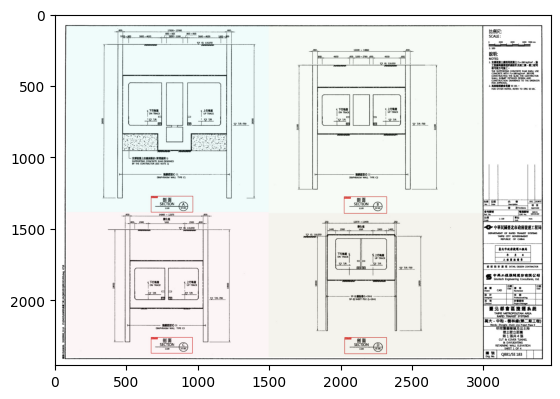

In [8]:
img = cv2.imread("prediction.jpg")
overlay = img.copy()
output = img.copy()
for block in block_split(result):
    # plot dirrenent color for each block
    color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
    # plot the block and  color the area
    cv2.rectangle(overlay, (int(block[0]), int(block[1])), (int(block[2]), int(block[3])), color, -1)
alpha = 0.1
cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0, output)
cv2.imwrite("block_split.jpg", output)
plt.imshow(output)
plt.show()

## OpenAI 作法

### 建立環境以及連線

In [9]:
from dotenv import load_dotenv, find_dotenv
from openai import AzureOpenAI
import os
import json

import base64
from mimetypes import guess_type

load_dotenv(find_dotenv())

api_base = os.getenv("GPT4V_ENDPOINT")
api_key= os.getenv("AZURE_OPENAI_API_KEY")
deployment_name = 'gpt4-vision'
api_version = '2023-12-01-preview'

client = AzureOpenAI(
    api_key=api_key,  
    api_version=api_version,
    base_url=f"{api_base}/openai/deployments/{deployment_name}/extensions",
)

# Function to encode a local image into data URL 
def local_image_to_data_url(image_path):
    # Guess the MIME type of the image based on the file extension
    mime_type, _ = guess_type(image_path)
    if mime_type is None:
        mime_type = 'application/octet-stream'  # Default MIME type if none is found

    # Read and encode the image file
    with open(image_path, "rb") as image_file:
        base64_encoded_data = base64.b64encode(image_file.read()).decode('utf-8')

    # Construct the data URL
    return f"data:{mime_type};base64,{base64_encoded_data}"

In [10]:
response_list = []
for i in range(len(block_images)):
    eval_section_img_path = f"eval_section_{i}.jpg"
    # save image
    cv2.imwrite(eval_section_img_path, block_images[i])
    # encode image
    image_data_url = local_image_to_data_url(f"eval_section_{i}.jpg")
    # call api
    template = "Tell me if the drawing is about sheet pile, if not return 'None', if yes tell me the type of the sheet pile and the lenght of it. please response as the following template:{pile_type}-{length} e.g. SP-III-10m. just return the template, do not return any other information." 
    response = client.chat.completions.create(
        model=deployment_name,
        messages=[
            { "role": "system", "content": "You are a helpful assistant." },
            { "role": "user", "content": [  
                { 
                    "type": "text", 
                    "text": template
                },
                { 
                    "type": "image_url",
                    "image_url": {
                        "url": image_data_url
                    }
                }
            ] } 
        ],
        max_tokens=500
    )
    response_list.append(response)
    # delete image
    os.remove(eval_section_img_path)

In [12]:
for i in range(len(response_list)):
    print(response_list[i].choices[0].message.content)

None
None
None
SP-III-16m


### EasyOCR

In [18]:
# setup ocr reader
reader = easyocr.Reader(['en'])

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [29]:
bounds = reader.readtext(img_blur, detail=1)
array = np.array(img_blur, dtype=object)